# Introduction. I want to classify any user image by training on available satellite image. The training and test data set DeepSat(SAT-4) Airborne Dataset is from https://www.kaggle.com/arpandhatt/satellite-image-classification.

SAT-4

SAT-4 consists of a total of 500,000 image patches covering four broad land cover classes. These include - barren land, trees, grassland and a class that consists of all land cover classes other than the above three. 400,000 patches (comprising of four-fifths of the total dataset) were chosen for training and the remaining 100,000 (one-fifths) were chosen as the testing dataset. We ensured that the training and test datasets belong to disjoint set of image tiles. Each image patch is size normalized to 28x28 pixels. Once generated, both the training and testing datasets were randomized using a pseudo-random number generator.

The MAT file for the SAT-4 dataset contains the following variables:

train_x	28x28x4x400000 uint8 (containing 400000 training samples of 28x28 images each with 4 channels)
train_y	400000x4 uint8 (containing 4x1 vectors having labels for the 400000 training samples)
test_x	28x28x4x100000 uint8 (containing 100000 test samples of 28x28 images each with 4 channels)
test_y	100000x4 uint8 (containing 4x1 vectors having labels for the 100000 test samples)

## Section 1 input data

In [124]:
#import modules
import os
import copy
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from math import ceil
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model, load_model, Sequential, model_from_json
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization, LeakyReLU, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import rescale, resize


from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score, f1_score, classification_report

In [2]:
# read the satellite image csv file. The original file has 400,000 train samples and 100,000 test samples. 
x_train = pd.read_csv("X_train_sat4.csv", header=None)
x_test = pd.read_csv("X_test_sat4.csv", header=None)
y_train = pd.read_csv("y_train_sat4.csv", header=None)
y_test = pd.read_csv("y_test_sat4.csv", header=None)

In [3]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
0,104,103,94,133,114,115,106,145,104,110,...,95,141,101,103,92,138,103,110,99,148
1,175,149,130,146,169,148,130,141,166,139,...,119,132,137,133,121,134,134,128,119,132
2,113,114,105,163,126,131,125,176,119,125,...,129,177,122,126,113,172,130,136,131,181
3,107,104,100,124,108,105,102,126,105,104,...,74,85,74,70,63,78,83,79,73,92
4,105,100,95,132,77,72,62,114,76,77,...,86,129,106,100,85,128,118,109,99,130


In [4]:
x_train.shape

(400000, 3136)

In [5]:
y_train.shape

(400000, 4)

In [6]:
x_test.shape

(100000, 3136)

In [7]:
y_test.shape

(100000, 4)

## Section 2 EDA

In [8]:
#Convert the training and testing data into numpy array with shape of [image no, 28,28,4]
x_train_img = x_train.to_numpy().reshape([400000,28,28,4])
x_test_img = x_test.to_numpy().reshape([100000,28,28,4])

In [9]:
#convert x from pandas dataframe to numpy array
x_train_np = x_train.to_numpy()
x_test_np = x_test.to_numpy()

In [10]:
#convert label y from pandas dataframe to numpy array
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

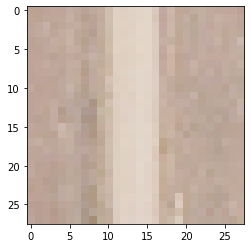

Barren Land


In [11]:
# Examine the image. The color channel are R,G,B, and I(Infrared)
# Type a image number between 0 and 400,000 to check the image.
ix = 10000
plt.imshow(x_train_img[ix,:,:,0:4])
plt.show()
#Tells what the image is
if y_train_np[ix,0] == 1:
    print ('Barren Land')
elif y_train_np[ix,1] == 1:
    print ('Trees')
elif y_train_np[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

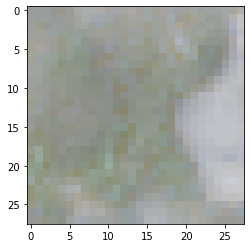

Trees


In [12]:
ix = 5000
plt.imshow(x_train_img[ix,:,:,0:4])
plt.show()
#Tells what the image is
if y_train_np[ix,0] == 1:
    print ('Barren Land')
elif y_train_np[ix,1] == 1:
    print ('Trees')
elif y_train_np[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

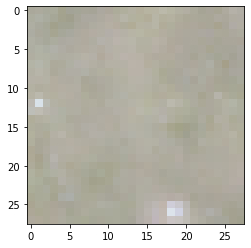

Grassland


In [13]:
ix = 39999
plt.imshow(x_train_img[ix,:,:,0:4])
plt.show()
#Tells what the image is
if y_train_np[ix,0] == 1:
    print ('Barren Land')
elif y_train_np[ix,1] == 1:
    print ('Trees')
elif y_train_np[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

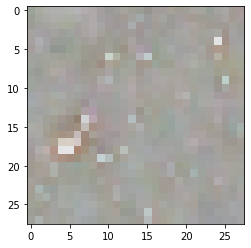

Other


In [14]:
ix = 20000
plt.imshow(x_train_img[ix,:,:,0:4])
plt.show()
#Tells what the image is
if y_train_np[ix,0] == 1:
    print ('Barren Land')
elif y_train_np[ix,1] == 1:
    print ('Trees')
elif y_train_np[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

In [15]:
# Check how many images in each class
sum = [0,0,0,0]
for i in range(len(y_train_np)):
    for j in range(4):
        sum[j] = sum[j]+y_train_np[i][j]

print("There are {} barren land, there are {} trees, there are {} grassland, there are {} others".format(sum[0], sum[1], sum[2], sum[3]))

There are 104465 barren land, there are 81118 trees, there are 72017 grassland, there are 142400 others


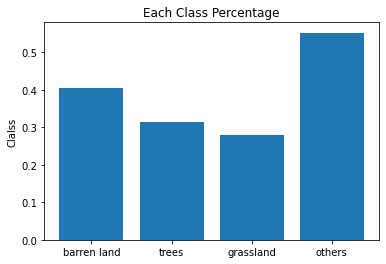

In [16]:
total = 0
for i in range(3):
    total = total + sum[i]
percent = sum / total
objects = ('barren land', 'trees', 'grassland', 'others')
y_pos = np.arange(len(objects))

plt.bar(y_pos, percent, align='center', alpha=1)
plt.xticks(y_pos, objects)
plt.ylabel('Clalss')
plt.title('Each Class Percentage')
plt.show()

## Section 3 Model Test

### Section 3.1 Deep neural network
This model is only for education purpose

In [26]:
# Now we normalize data. This means we make the mean 0, and the standard deviation 1 for the best results. However, dividing the image by 255 is good enough. We will just divide the array by 255:
x_train_norm = x_train / 255
x_test_norm = x_test / 255

In [27]:
# Deep neural network model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(3136,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [28]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# Train data

# Save model parameter in the file "weights.hdf5"
checkpoint_1 = ModelCheckpoint('dnn_weights.hdf5', monitor='val_loss', save_best_only=True)
# Store in a list to be used during training
callbacks_list_1 = [checkpoint_1]


r = model.fit(x_train_norm, y_train_np, validation_split=0.2, epochs=200, verbose=0)


Text(0.5, 1.0, 'Loss of train and validation data in each epoch')

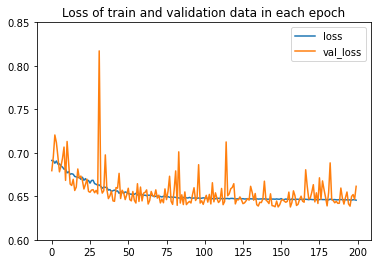

In [39]:
# Plot what's returned by model.fit()
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.ylim((0.6,0.85))
plt.legend()
plt.title('Loss of train and validation data in each epoch')

Text(0.5, 1.0, 'Accuracy of train and validation data in each epoch')

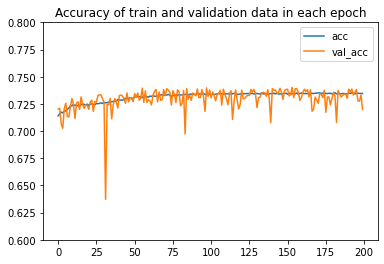

In [43]:
# Plot the accuracy too
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.ylim((0.6,0.8))
plt.legend()
plt.title('Accuracy of train and validation data in each epoch')

In [23]:
# Evaluate the model - evaluate() returns loss and accuracy
print("Train score:", model.evaluate(x_train_norm, y_train_np))
print("Test score:", model.evaluate(x_test_norm, y_test_np))

12500/12500 [==============================] - 9s 754us/step - loss: 1.3506 - accuracy: 0.3560
Train score: [1.3505929708480835, 0.35600000619888306]
3125/3125 [==============================] - 2s 733us/step - loss: 1.3501 - accuracy: 0.3563
Test score: [1.3501445055007935, 0.3563399910926819]


In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                31370     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 44        
Total params: 31,524
Trainable params: 31,524
Non-trainable params: 0
_________________________________________________________________


In [63]:
# Serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# Serialize weights to HDF5
model.save_weights("dnn_model.h5")
print("Saved model to disk")

Saved model to disk


In [67]:
# For later prediction
# Load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("dnn_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [68]:
# Evaluate loaded model on test data
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
eva = loaded_model.evaluate(x_test_norm, y_test_np)

3125/3125 [==============================] - 2s 784us/step - loss: 0.6600 - accuracy: 0.7192


In [71]:
print("Train score:", loaded_model.evaluate(x_train_norm, y_train_np))
print("Test score:", loaded_model.evaluate(x_test_norm, y_test_np))

12500/12500 [==============================] - 10s 811us/step - loss: 0.6593 - accuracy: 0.7206
Train score: [0.6592593193054199, 0.7206400036811829]
3125/3125 [==============================] - 2s 790us/step - loss: 0.6600 - accuracy: 0.7192
Test score: [0.6600294709205627, 0.7191699743270874]


In [96]:
y_test_pred_dnn = list(loaded_model.predict_classes(x_test_norm))

In [128]:
# Change y_test from dummy to lable 0-3
y_test_label = y_test.idxmax(axis=1)

In [131]:
# Model evaluation, check model performance using confusion matrix

ac = accuracy_score(y_test_label, y_test_pred_dnn)
f1 = f1_score(y_test_label, y_test_pred_dnn, average='weighted')
cm = confusion_matrix(y_test_label, y_test_pred_dnn)
print('Deep Neural Network: Accuracy=%.3f' % (ac))
print('Deep Neural Network: f1-score=%.3f' % (f1))
print(classification_report(y_test_label, y_test_pred_dnn))

Deep Neural Network: Accuracy=0.719
Deep Neural Network: f1-score=0.704
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     26189
           1       0.68      0.84      0.75     20231
           2       0.56      0.31      0.40     17946
           3       0.70      0.70      0.70     35634

    accuracy                           0.72    100000
   macro avg       0.69      0.70      0.68    100000
weighted avg       0.71      0.72      0.70    100000



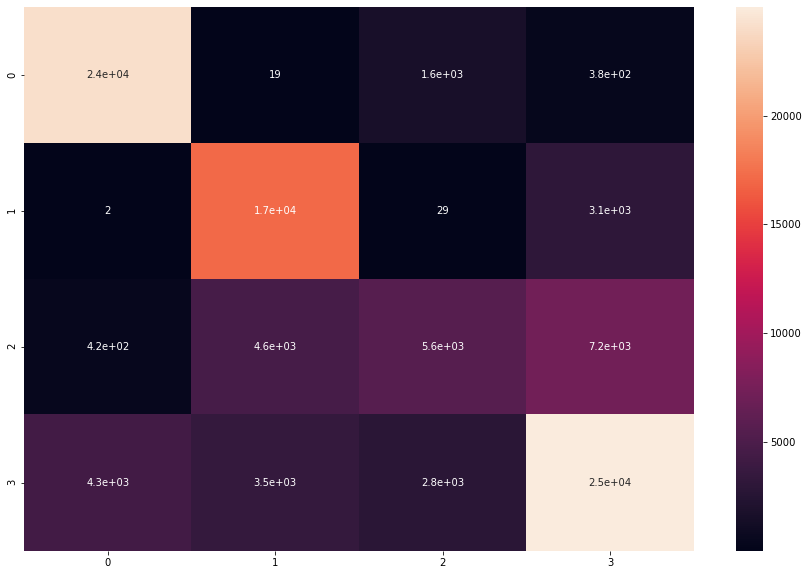

In [130]:
#Plot non_normalized confustion matrix
import seaborn as sn
plt.figure(figsize = (15,10))
sn.heatmap(cm, annot=True)
plt.show()

## This results from general deep neural network is not good. We will test convolution neural network model.

### Section 3.2 Convolution neural network

In [132]:
# Prepare data for cnn model
x_train_img_norm = x_train_img / 255
x_test_img_norm = x_test_img / 255

In [133]:
x_train_img.shape

(400000, 28, 28, 4)

In [134]:
# Build convolution network
cnn_model = Sequential()
cnn_model.add(Conv2D(10, kernel_size=3, activation='relu', input_shape=(28, 28, 4), padding='same'))
cnn_model.add(Dropout(0.25))
#cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(10, kernel_size=3, activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(4, activation='softmax'))

In [135]:
# Compile model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [136]:
# Save model parameter in the file "weights.hdf5"
checkpoint = ModelCheckpoint('cnn_weights.hdf5', monitor='val_loss', save_best_only=True)
# Store in a list to be used during training
callbacks_list = [checkpoint]

# Fit the model on a training set, using the checkpoint as a callback
r_cnn = cnn_model.fit(x_train_img_norm, y_train_np, validation_split=0.2, epochs=100, callbacks=callbacks_list, verbose=0)

In [144]:
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        370       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 10)        910       
_________________________________________________________________
flatten (Flatten)            (None, 6760)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 27044     
Total params: 28,324
Trainable params: 28,324
Non-trainable params: 0
_________________________________________________________________
None


In [140]:
# Evaluate the model - evaluate() returns loss and accuracy
print("Train score:", cnn_model.evaluate(x_train_img_norm, y_train_np))
print("Test score:", cnn_model.evaluate(x_test_img_norm, y_test_np))

12500/12500 [==============================] - 33s 3ms/step - loss: 0.0937 - accuracy: 0.9728
Train score: [0.09369296580553055, 0.9727824926376343]
3125/3125 [==============================] - 9s 3ms/step - loss: 0.1047 - accuracy: 0.9707
Test score: [0.1046617180109024, 0.9707300066947937]


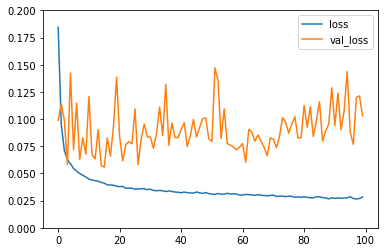

In [148]:
# Plot what's returned by model.fit()
plt.plot(r_cnn.history['loss'], label='loss')
plt.plot(r_cnn.history['val_loss'], label='val_loss')
plt.ylim((0,0.2))
plt.legend()
plt.show()

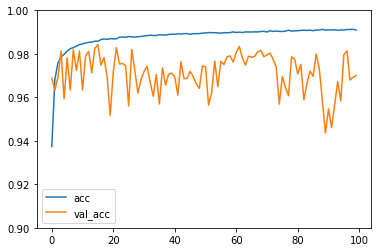

In [147]:
# Plot the accuracy too
plt.plot(r_cnn.history['accuracy'], label='acc')
plt.plot(r_cnn.history['val_accuracy'], label='val_acc')
plt.ylim((0.9,1))
plt.legend()
plt.show()

In [149]:
y_test_pred_cnn = list(cnn_model.predict_classes(x_test_img_norm))

In [429]:
# Model evaluation, check model performance using confusion matrix

ac = accuracy_score(y_test_label, y_test_pred_cnn)
f1 = f1_score(y_test_label, y_test_pred_dnn, average='weighted')
cm = confusion_matrix(y_test_label, y_test_pred_cnn)
print('CNN: Accuracy=%.3f' % (ac))
print('CNN: f1-score=%.3f' % (f1))
print(classification_report(y_test_label, y_test_pred_cnn))

CNN: Accuracy=0.971
CNN: f1-score=0.704
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     26189
           1       0.99      0.99      0.99     20231
           2       0.89      0.99      0.93     17946
           3       0.99      0.98      0.99     35634

    accuracy                           0.97    100000
   macro avg       0.97      0.97      0.97    100000
weighted avg       0.97      0.97      0.97    100000



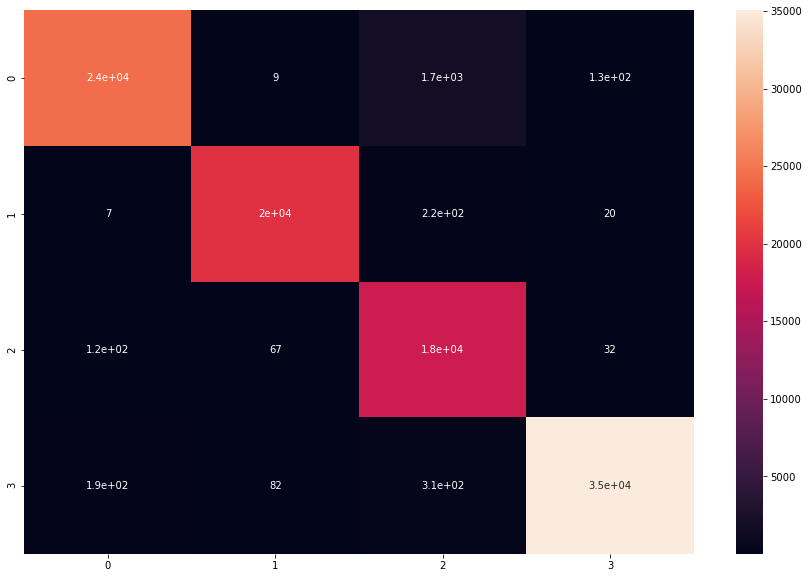

In [151]:
#Plot non_normalized confustion matrix
import seaborn as sn
plt.figure(figsize = (15,10))
sn.heatmap(cm, annot=True)
plt.show()

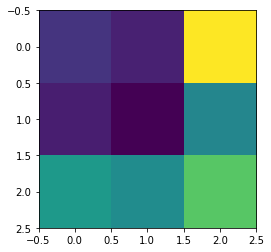

In [152]:
# Interpreting model
# Visulize the kernel
conv1 = cnn_model.layers[0]
weights1 = conv1.get_weights()
kernels1 = weights1[0]
kernel1_1 = kernels1[:,:, 0, 0]
plt.imshow(kernel1_1)
plt.show()

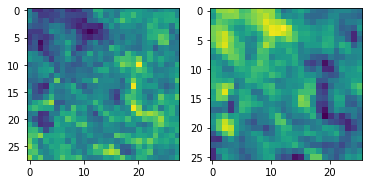

In [153]:
# Check what does the first kernel do to the image
# pick the 4th image in the training set
test_image = x_train_img_norm[4,:,:,0]

# convolve this image with kernel
conv_1 = np.zeros((26,26))
for i in range(26):
    for j in range(26):
        window = test_image[i:i+3, j:j+3]
        conv_1[i,j] = np.sum(window*kernel1_1)

#plt these two images

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(test_image)
ax2.imshow(conv_1)
plt.show()

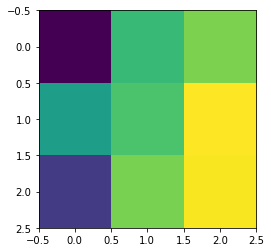

In [157]:
# Visulize the kernel at layer 2
conv2 = cnn_model.layers[2]
weights2 = conv2.get_weights()
kernels2 = weights2[0]
kernel2_1 = kernels2[:,:, 0, 0]
plt.imshow(kernel2_1)
plt.show()

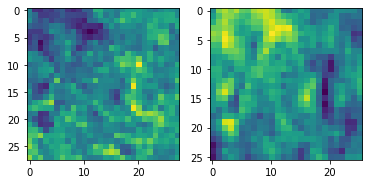

In [158]:
# Check what does the second kernel do to the image

# convolve this image with kernel
conv_2 = np.zeros((26,26))
for i in range(26):
    for j in range(26):
        window = test_image[i:i+3, j:j+3]
        conv_2[i,j] = np.sum(window*kernel2_1)

#plt these two images

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(test_image)
ax2.imshow(conv_2)
plt.show()

## Section 4 Test trained cnn model on new images I downloaded online

In [170]:
# cd to my image directory
path = os.getcwd()

In [ ]:
# os.chdir(file_path + '/'+'Grace_Test_Image') 

In [395]:
item_dict = {}
item_res = []

class_list = [name for name in os.listdir() if os.path.isdir(os.path.join(name))]
for class_cur in class_list:
  each_category_list = os.listdir(class_cur)
  for item in each_category_list:
    img_path = class_cur + r"/" + item
    img = image.load_img(img_path, target_size=(28, 28,))
    x = image.img_to_array(img)
    x_flatten = x.flatten()
    item_dict.setdefault(str(x_flatten), []).append(img_path)
    item_res.append(x_flatten)
    if len(item_res)%1 == 0:
      print(len(item_res))
      print(img_path)

1
barren/1.jpg
2
barren/dfghd.jpg
3
grass/aed.jpeg
4
grass/dfef.jpg
5
other/1dr.jpg
6
other/aster-netherlands-dikes.jpg
7
trees/sdf.jpg
8
trees/test_image_gpradar.png
9
trees/th.jpg


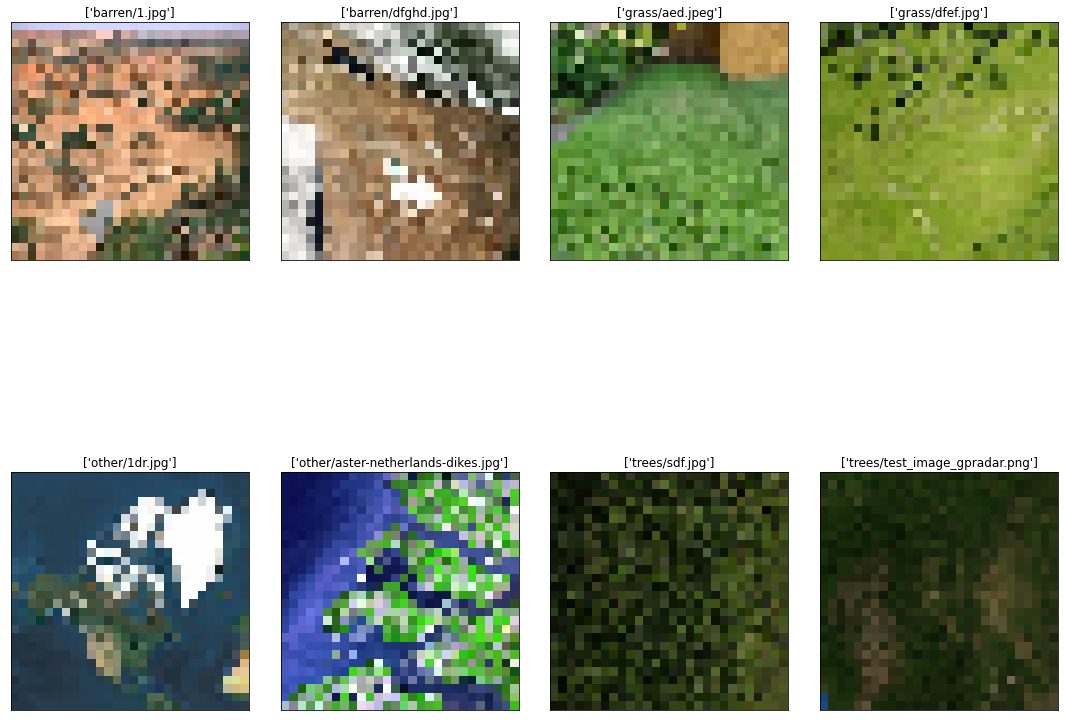

In [418]:
# Print these 8 figures
fig, axes = plt.subplots(2,4, figsize=(15,15))
for x, y, ax in zip(np.array(item_res)/255, item_dict.values(), axes.ravel()):
    ax.set_title(y) # ax represent each of the 8 figures
    ax.imshow(x.reshape(28,28,3), cmap='plasma')
    ax.set_xticks(())
    ax.set_yticks(())
plt.tight_layout()

In [417]:
# Because all these images only have 3 channels, I add the average of these three channels as the 4th channel to fit the model
item_res_np = np.array(item_res)
height = 28
width = 28
num = len(item_res_np)
chan = 4
# Define an empty array (8, 28, 28, 4)
item_res_np_4chan = np.zeros((num, height, width, chan))
for k in range(len(item_res_np)):
    new = np.empty((28, 28, 4))
    each_figure = each_figure.reshape(28,28,3)
    # in the loop (28,28,3) change into (28, 28, 4), fill the 4th channel with mean of the RGB channel.
    for i in range(28):
        for j in range(28):
            pix_3chan = each_figure[i][j]
            chan4 = round(np.mean(pix_3chan))
            # expand pix_4chan from 3 to 4 elements
            pix_4chan = np.append(pix_3chan, chan4) 
            new[i][j] = pix_4chan     
     ##
    item_res_np_4chan[k] = new
    
print(item_res_np_4chan[0][0][0])
    

[190. 189. 229. 203.]


In [407]:
cnn_model.predict_classes(item_res_np_4chan/255 )

array([3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

### The problem here is all input data is 3 color channel, I artificially add 4th color channel as zero or mean of 3 channels. I think this cause the CNN model confused.


### Seperate test for a original 4 channales picture.

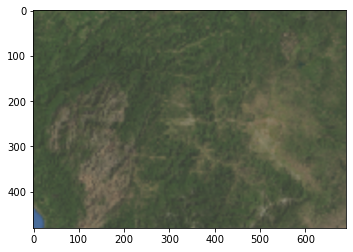

In [408]:
# read test images, imges is from GrantsPassWeather.com - Locall Satellite Image
test_img = plt.imread('test_image_gpradar.png')
plt.imshow(test_img)

In [409]:
test_img.shape

(480, 690, 4)

In [410]:
from PIL import Image
img = Image.open('test_image_gpradar.png') # image extension *.png,*.jpg
new_width  = 28
new_height = 28
img = img.resize((new_width, new_height), Image.ANTIALIAS)
img.save('test_image_gpradar_resize.png') 

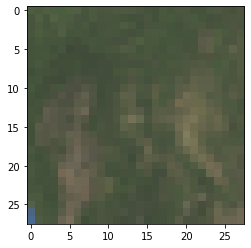

In [411]:
test_img2 = plt.imread('test_image_gpradar_resize.png')
plt.imshow(test_img2)

In [412]:
test_img2.shape

(28, 28, 4)

In [413]:
# Convert the array into same shape as training data set 
an_img = []
an_img.append(test_img2)
np_img = np.array(an_img)

In [414]:
np_img.shape

(1, 28, 28, 4)

In [415]:
# Predict the image is grassland
cnn_model.predict_classes(np_img )

array([2], dtype=int64)

### Section 3.3 GAN model

In [439]:
N, H, W, C = x_train_img_norm.shape
D = H * W * C

In [440]:
# # Dimensionality of the latent space
latent_dim = 100

In [441]:
# Get the generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(D, activation='tanh')(x)
    
    model = Model(i, x)
    return model

In [442]:
# Get the discriminator model
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i,x)
    return model   

In [443]:
# Compile both models in preparation for training

# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# Take true output is fake, but we label them real!
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


In [449]:
combined_model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
functional_9 (Functional)    (None, 3136)              3321920   
_________________________________________________________________
functional_7 (Functional)    (None, 1)                 1737729   
Total params: 5,059,649
Trainable params: 3,319,872
Non-trainable params: 1,739,777
_________________________________________________________________


In [444]:
# Train the GAN

# Config
batch_size = 32
epochs = 300
sample_period = 10 # every 'sample_period' steps generate and save some data

# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [445]:
# A function to generate a grid of random samples from the generator and save them to a file
def sample_images(epoch):
    rows, cols = 3, 3
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)
    
    # Rescale images 0 - 1
    imgs = 0.5 * imgs + 0.5
    
    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W, C), cmap='rainbow')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [446]:
# Now we normalize data. This means we make the mean 0, and the standard deviation 1 for the best results. However, dividing the image by 255 is good enough. We will just divide the array by 255:
x_train_np_norm = x_train_np / 255
x_test_np_norm = x_test_np / 255

In [447]:
# Main training loop
for epoch in range(epochs):
    ## Train discriminator##
    
    # Select a random batch of images
    idx = np.random.randint(0, x_train_np_norm.shape[0], batch_size)
    real_imgs = x_train_np_norm[idx]
   
    
    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    
    #Train the dsicriminator
    # both loss and accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real  + d_acc_fake)
    
    
    ## Train generator
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 50 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
              
    if epoch % sample_period == 0:
        sample_images(epoch)

epoch: 1/30, d_loss: 0.85, d_acc: 0.47, g_loss: 0.93


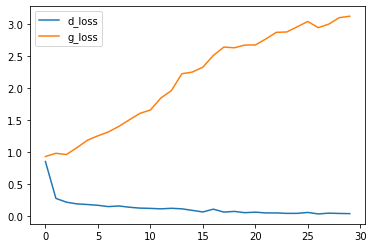

In [448]:
plt.plot(d_losses, label = 'd_loss')
plt.plot(g_losses, label = 'g_loss')
plt.legend()
plt.show()

In [ ]:
ls gan_images

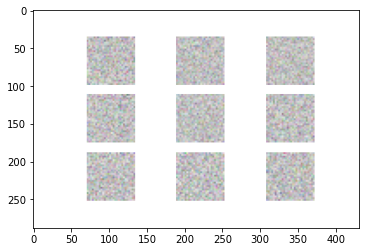

In [451]:
#get the images at the beginning training phase
a = imread('gan_images/0.png')
plt.imshow(a)

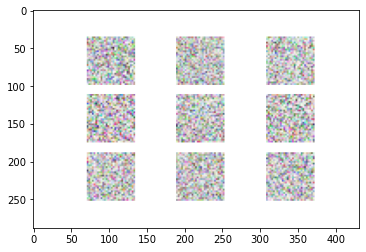

In [452]:
#get the images at the middle training phase
a = imread('gan_images/15.png')
plt.imshow(a)

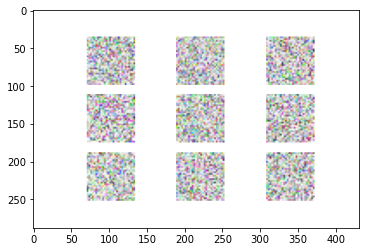

In [453]:
#get the images at the middle training phase
a = imread('gan_images/29.png')
plt.imshow(a)

In [ ]:
# save the model